# DM4: Résaux de neurones : modèles de taux de décharge

Dans le TD, nous avons étudié la dynamique de réseaux de neurones où une *population de neurones* est représentée par son taux de décharge moyen. Les connexions récurrentes entre neurones dans de cette population sont prises en compte via un couplage effectif de la population à elle-même, avec un "poids" de connexion $w$ :

$$\frac{dr}{dt} = \frac{\Phi(I_{ext}+wr(t)) - r(t)}{\tau}$$ 

Nous avons considéré une population inhibitrice ($w<0$) ainsi qu'une population excitratrice ($w>0$).

Dans un cas plus générale, on peut considérer plusieurs populations qui peuvent être couplées entre elles par des connexions synaptiques, ce qui rend la dynamique de ces modèles potentiellement très riche, ce qui est déjà le cas si on considère deux populations avec des connexions récurrentes (entre une population est elle-même du coup) et entre les deux populations. 

Dans ce devoir, nous allons cependant étudier davantage les modèles avec une seule population. Nous avons vu comment un ou plusieurs points fixes apparaissent en fonction des paramètres (le courant externe et le poids de connexion). Quand le système a atteint un point fixe stable, le taux de décharge $r^*$ de la population est donné par le courant total rentrant $I_{\rm tot} = I_{\rm ext} + wr^*$, via la fonction de transfert $\Phi(I)$ :

$$r^* = \Phi(I_{\rm ext} + w r^*)$$

Cette équation ne peut pas être résolu simplement pour calculer $r^*$ ; mais on peut déjà voir que s'il y a des connexions récurrents ($w\neq0$), le taux de décharge final est différent du taux auquel on s'attendrait uniquement en partant du courant externe, $r^*\neq\Phi(I_{\rm ext})$. Quel est alors la rélation entre le taux de décharge final et la stimulation par un courant externe en présence d'un couplage récurrent ? Dans le TP, nous avons également déterminé la fonction de transfert *effective* qui exprime $r^*$ en fonction de $I_{\rm ext}$ :

$$ r^* = F(I_{\rm ext}) $$.

On a vu que pour un réseau récurrent, il peut y avoir un régime de **bistabilité** où pour une seule valeur de $I_{ext}$, deux états d'activité différents sont stables. Grâce à cette bistabilité, un réseau récurrent excitateur peut déjà implémenter une (très simple) fonction cognitive : servir comme **mémoire** ! Nous allons explorer cela davantage dans ce DM. 


## Exercise : Implémentation d'un switch d'activité d'un réseau récurrent excitateur

Considérez un réseau récurrent excitateur comme dans le TP, avec `w = 0.1`. Ce réseau est initialement faiblement actif, en présence d'un courant externe `Iext = - 10.`. 

Déterminez l'évolution temporelle (le décours dans le temps) du taux de décharge de la population $r(t)$ dans les conditions suivantes :

- L'état initiale (à $t = 0$) du réseau est donné par `r0 = 1` pour commencer avec un réseau qui est faiblement actif.
- Evoluez le réseau pendant pendant 10 unités de temps (jusqu'à $t=10$) avec `Iext = -10.`.
- A $t=10$, augmentez le courant externe temporairement pour une unité de temps (entre $t=10$ et $t=11$) à `Iext = 10.`, et évoluez le réseau pendant cette période.
- A $t=11$, diminuez le courant à son niveau intiale, `Iext = -10.` et évoluez le réseau pour encore 10 unités de tems, c'est-à-dire jusqu'à $t=21$.

Vous pouvez soit (1) utiliser la méthode d'Euler pour l'intégration numérique de l'équation différentielle, vieillez dans ce cas simplement à choisir la valeur correcte du courant externe en fonction du temps, et de choisir un pas de temps suffisamment petit pour que le résultat ne dépend pas du choix de ce pas de temps. 

Vous pouvez sinon (2) utiliser la routine `odeint`. Dans ce cas, vous pourriez (2a) simplement déterminer les différents époques (0-10, 10-11, 11-21) comme dans le TD, avec la bonne valeur de $I_{ext}$ pour chaque époque, et en veillant à utiliser comme valeur initiale pour la prochain bout la dernière valeure du bout juste avant. Sinon, l'autre possibilité (2b) serait de modifier la fonction `drdt` pour que le courant dépend explicitement du temps `t` (et n'est plus donné comme argument avec une valeur constante) ; si vous choississez cette option, il faudra veiller à préciser lors de l'appel de `odeint` qu'il y a des temps critique pour lequel la dynamique change (regardez la documentation d'`odeint`). 

In [2]:
# import necessary modules for numerics and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Definition of the f-I curve 

# set standard parameters 
# --> these will be used as default parameters
# in the function definitions
rmax = 500.0     # (could be Hz)
Ihalf = 10.0   # (could be pA)
kappa = 0.2  # (1/unit of current)

# f-I curve
def fI(I):
    """fI(I, kwargs**) returns the population firing rate (in Hz) 
    for a given input current I (in mV)."""
    return rmax*0.5*(1.0+np.tanh((I-Ihalf)*kappa))

In [4]:
# définissez la dérivée dr/dt(r,t) (la fonction 'f'
# des TD précédents) 

def drdt(r, t, I, w):
    """Dynamics of population rate r
    for a single, recurrently connected
    population.
    
    Arguments:
    r - current rate
    t - currrent time (not used)
    I - external input current to population
    w - weight of recurrent connection
    
    Output:
    dr/dt
    """
    return fI(I + w*r) - r

In [25]:
# votre code

T = 21.  # la durée totale
t1 = 10. # augmentation de I 
t2 = 11. # retour à I d'avant

r0 = 1. # valeur initiale

I0 = -10. # courant initial bas
Iup = 10. # courant élevé

w = 0.1  # poids des connexions recurrents

# 1: la méthode d'Euler

dt = 0.01               # pas de temps
t = np.arange(0, T, dt) # discrétisation du temps
nt = len(t)

# initialisation de l'array pour le taux de décharge
r_euler = np.zeros(nt)
r_euler[0] = r0

# boucle sur les temps
for i in range(nt-1):
    # la valeur du courant dépend du temps
    if t[i]>=t1 and t[i]<t2:
        I = Iup
    else:
        I = I0
    # méthode d'Euler
    r_euler[i+1] = r_euler[i] + dt*drdt(r_euler[i],None,I,w) # drdt ne dépend pas explicitement du temps
    




Text(0, 0.5, 'rate')

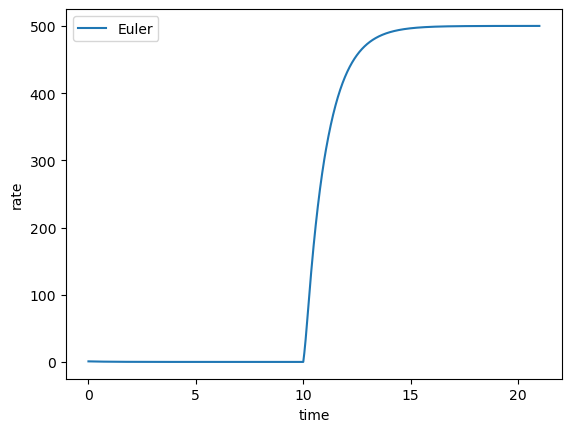

In [26]:
# plot 
fig, ax = plt.subplots()
ax.plot(t, r_euler, label='Euler')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('rate')

In [27]:
# 1b: avec odeint et en passant les temps 'critiques'

from scipy.integrate import odeint

# redefinition de la fonction drdt
def drdt_mod(r, t):
    if t>=t1 and t<t2:
        I = Iup
    else:
        I = I0
    return fI(I + w*r) - r

# odeint
r_odeint_b = odeint(drdt_mod, r0, t, tcrit=[t1,t2])    




Text(0, 0.5, 'rate')

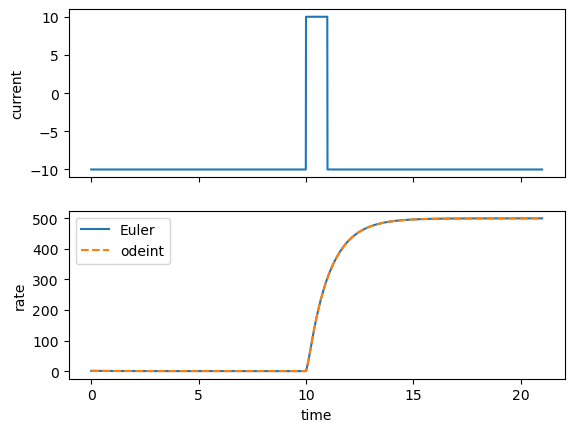

In [29]:
# un peu plus complet avec un plot du courant
I = I0*np.ones(nt)
I[(t>=t1)*(t<t2)] = Iup

fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(t, I)
ax[0].set_ylabel('current')
ax[1].plot(t, r_euler, label='Euler')
ax[1].plot(t, r_odeint_b, '--', label='odeint')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('rate')